# Importing Libraries needed

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os


# Data Preprocessing

## loading dataset

This notebook was created in Google Colab due to the large dataset so we utilised google drive that had the said dataset saved, the data is still within the project folder so if your device can run it just change the imports

In [ ]:
df = "/content/drive/MyDrive/data"
categories = ["with_mask", "without_mask"]
print("loading images...")

loading images...


Here we load up every image and their labels from the folders, the image is entered into the empty data list while their catergory is entered into the empty labels list.

The images are all loaded with the same size for consistency.

The images are then transformed into a numerical format so the model can understand.

We then scale the pixel values so they're suitable for the MobileNetV2 model.

In [ ]:
data = []
labels = []

for category in categories:
    path = os.path.join(df, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)

        data.append(image)
        labels.append(category)

perform one-hot encoding on the labels so the model can categorize and understand

In [ ]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

train and test data

In [ ]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,
                                                  test_size=0.20, stratify=labels, random_state=42)

creating the training image generator for data augmentation.

What the augmentation does here is it increases the amount of data whether its by rotating the image by 20 degrees, zooms in by 15%, etc...

As for if there is a missing pixel, it is filled out by its nearest pixel value.

In [ ]:
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range = 0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

# Creating the Model

Here the base model is used for general purposing which is utilising a pretrained model to detect the persons face whether its lookins sideways upwards or downwards.

In [ ]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,
                    input_tensor=Input(shape=(224, 224, 3)))

<ipython-input-49-b41532d275fc>:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  baseModel = MobileNetV2(weights="imagenet", include_top=False,


Here we build upon the basemodel by adding new layers on top of it, these layers perform the face mask classification according to the input from the baseModel.

In [ ]:
headModel = baseModel.output
#This adds an Average Pooling layer. This layer reduces the spatial dimensions of the feature maps while retaining the most important information.
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
#Flattens the output of the pooling layer into a one-dimensional vector.
#This is necessary because the subsequent Dense layers expect a 1D input.
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

We start to combine the baseModel and headModel into 1 model where the baseModel is the input and the headModel as the output.

In [ ]:
model = Model(inputs=baseModel.input, outputs=headModel)

In [ ]:
for layer in baseModel.layers:
  layer.trainable = False

In [ ]:
print("compiling model...")
#The decay is used in order to help the optimizer to reduce the learning rate over time and converge to a better solution.
#This is particularly useful in deep learning models where the initial learning rate might be too high.
opt = Adam(learning_rate=1e-4, decay=1e-4 / 20)
model.compile(loss="binary_crossentropy", optimizer=opt,
              metrics=["accuracy"])

compiling model...


/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [ ]:
print("training head...")
#The fit method is used to train the model on the training data.
#The steps_per_epoch is the number of batches to draw from the generator before declaring one epoch and the same for validation_steps.
head = model.fit(
    aug.flow(trainX, trainY, batch_size=32),
    steps_per_epoch=len(trainX) // 32,
    validation_data=(testX, testY),
    validation_steps = len(testX) // 32,
    epochs=20
)

training head...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_318']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


34/34 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.7440 - loss: 0.6079 - val_accuracy: 0.9964 - val_loss: 0.2046
Epoch 2/20
 1/34 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.9375 - loss: 0.2955

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


34/34 ━━━━━━━━━━━━━━━━━━━━ 12s 327ms/step - accuracy: 0.9375 - loss: 0.2955 - val_accuracy: 0.9964 - val_loss: 0.1990
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - accuracy: 0.9728 - loss: 0.2148 - val_accuracy: 0.9928 - val_loss: 0.0991
Epoch 4/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 12s 312ms/step - accuracy: 1.0000 - loss: 0.1034 - val_accuracy: 0.9928 - val_loss: 0.0977
Epoch 5/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.9598 - loss: 0.1409 - val_accuracy: 0.9964 - val_loss: 0.0618
Epoch 6/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 11s 311ms/step - accuracy: 1.0000 - loss: 0.0802 - val_accuracy: 0.9964 - val_loss: 0.0611
Epoch 7/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 132s 2s/step - accuracy: 0.9821 - loss: 0.0863 - val_accuracy: 0.9928 - val_loss: 0.0448
Epoch 8/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 22s 622ms/step - accuracy: 0.9688 - loss: 0.0757 - val_accuracy: 0.9928 - val_loss: 0.0443
Epoch 9/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.9846 - loss: 0.0743 - val_accuracy: 0.9928 - val_los

In [ ]:
print("evaluating network...")
predIdxs = model.predict(testX, batch_size=32)
predIdxs = np.argmax(predIdxs, axis=1)

evaluating network...


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_318']
Received: inputs=Tensor(shape=(32, 224, 224, 3))
  warnings.warn(msg)


9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step


In [ ]:
print(classification_report(testY.argmax(axis=1), predIdxs,
                            target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       1.00      1.00      1.00       138
without_mask       1.00      1.00      1.00       138

    accuracy                           1.00       276
   macro avg       1.00      1.00      1.00       276
weighted avg       1.00      1.00      1.00       276



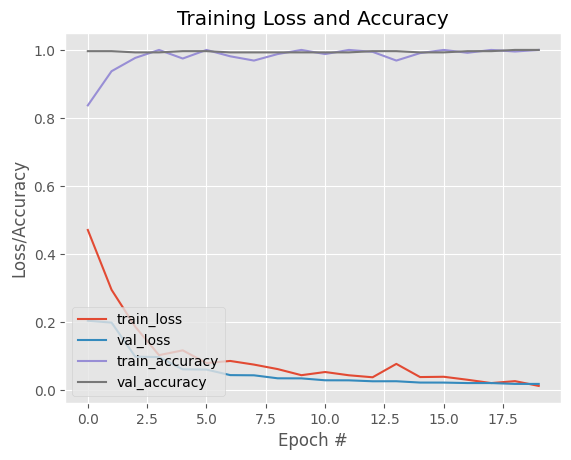

In [ ]:
N = len(head.history["loss"])
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), head.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), head.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), head.history["accuracy"], label="train_accuracy")
plt.plot(np.arange(0, N), head.history["val_accuracy"], label="val_accuracy")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")


# Saving Model

In [ ]:
model.save("mask_detection.h5")